In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rnd
import cv2 as cv
from skimage.transform import resize
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import Javascript
from numpy import linalg as alg
import warnings
#from google.colab import drive
#drive.mount('/content/drive')

#Lectura de imagenes

Imagen de prueba a color

(150, 180, 3)

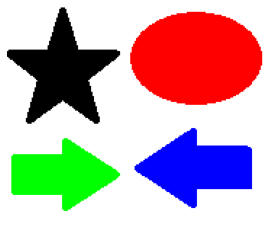

In [ ]:
#Lectura de imagen
im0= plt.imread('https://github.com/JuanDavid1703/Markov-Proyect/raw/main/Image/Pruebacolor.png')[:,:,0:3]
ancho=np.shape(im0)[1]
alto=np.shape(im0)[0]
#Método para quitar las singularidades
for i in range(alto):
  for j in range(ancho):
    im0[i,j,:]=np.where(im0[i,j,:]!=0,im0[i,j,:],1e-20)
plt.imshow(im0)
plt.axis("off")
np.shape(im0)

Funciones de transformación

In [ ]:
def Luvt(M, X0,u0,v0):
  try:
    Luv=np.zeros((np.shape(M)[0],np.shape(M)[1],3))
    Luv[:,:,0]=116*(M[:,:,0]/X0)**(1/3)-16
    Luv[:,:,1]=13*Luv[:,:,0]*(4* M[:,:,0]/(M[:,:,0]+15*M[:,:,1]+3*M[:,:,2])-u0)
    Luv[:,:,2]=13*Luv[:,:,0]*(6* M[:,:,1]/(M[:,:,0]+15*M[:,:,1]+3*M[:,:,2])-v0)
  except:
    Luv=np.zeros((3,1))
    Luv[0,0]=116*(M[0,0]/X0)**(1/3)-16
    Luv[1,0]=13*Luv[0,0]*(4* M[0,0]/(M[0,0]+15*M[1,0]+3*M[2,0])-u0)
    Luv[2,0]=13*Luv[0,0]*(6* M[1,0]/(M[0,0]+15*M[1,0]+3*M[2,0])-v0)
  return Luv

Transformación de espacio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


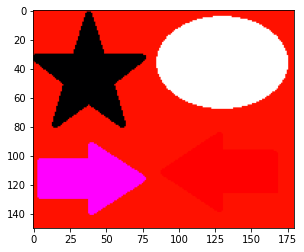

In [ ]:
M_CIE=np.array([[0.607,0.174, 0.200],[0.299,0.587, 0.114],[0, 0.066, 1.116]])
CIE=np.zeros((np.shape(im0)[0],np.shape(im0)[1],3))
for i in range(np.shape(im0)[0]):
  for j in range(np.shape(im0)[1]):
    CIE[i,j]=M_CIE@im0[i,j]
X0=1
u0=0.2009
v0=0.3073
im0Luv=Luvt(CIE,X0,u0,v0)
plt.imshow(im0Luv) 

Vectores de referencias de color $\mu_k$

In [ ]:
Blanco=np.ones((3,1))
Blanco=Luvt(M_CIE@Blanco,X0,u0,v0)

Negro=np.zeros((3,1))+1e-20
Negro=Luvt(M_CIE@Negro,X0,u0,v0)

Rojo=np.zeros((3,1))
Rojo[0]=1
Rojo=Luvt(M_CIE@Rojo,X0,u0,v0)

Verde=np.zeros((3,1))
Verde[1]=1
Verde=Luvt(M_CIE@Verde,X0,u0,v0)

Azul=np.zeros((3,1))
Azul[2]=1
Azul=Luvt(M_CIE@Azul,X0,u0,v0)

Etiquetas=[Blanco, Negro, Rojo, Verde, Azul]

#generando imagenes multicolor

Generación de imagen de etiquetas

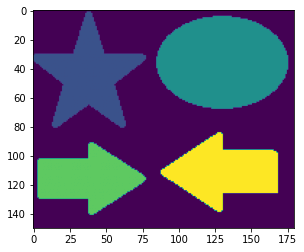

In [ ]:
ImEtiqueta=np.zeros((alto,ancho))
SW=[]
for i in range(alto):
  for j in range(ancho):
    sw=0
    for etiq in Etiquetas:
      d=alg.norm(etiq.T-im0Luv[i,j,:])
      if d<=1:
        break
      else:
        sw+=1
    SW.append(sw)
    ImEtiqueta[i,j]=sw

Vector_Prob=[SW.count(0)/len(SW),SW.count(1)/len(SW),SW.count(2)/len(SW),SW.count(3)/len(SW),SW.count(4)/len(SW)]

plt.imshow(ImEtiqueta)

In [ ]:
def potunary(ui,ob):
  #Nomalización
  #un=np.array(ui/alg.norm(ui))
  #obn=np.array(ob/alg.norm(ob))  
  if np.abs(ui-ob)>0:
    return 1
  else:
    return 0

def potpair(ui,uj,t):
  #Normalización
  #uin=np.array(ui/alg.norm(ui))
  #ujn=np.array(uj/alg.norm(uj))
  return min(np.abs(ui-uj),t)

def energy(L,L0,t):
  E=[]
  alt=np.shape(L)[0]
  anc=np.shape(L)[1]
  for i in range(alt):
    for j in range(anc):
      if i==alt-1:
        if j==anc-1:
          u=potunary(L[i,j],L0[i,j])
          E.append(u)
          continue
        else:
          u=potunary(L[i,j],L0[i,j])
          f=potpair(L[i,j],L[i,j+1],t)
          E.append(u+f)
      else:
        if j==anc-1:
          u=potunary(L[i,j],L0[i,j])
          a=potpair(L[i,j],L[i+1,j],t)
          E.append(u+a)
        else:
          u=potunary(L[i,j+1],L0[i,j])
          f=potpair(L[i,j+1],L[i,j+1],t)
          a=potpair(L[i,j+1],L[i+1,j],t)
          d=potpair(L[i,j+1],L[i+1,j+1],t)
          E.append(u+(a+d+f))
  return np.sum(E)



###Algoritmo de Metrópólis reconstrucción de imagen a color

In [ ]:
#Generación de una imagen aleatoria con 5 valores distintos
i0=np.random.choice([0,1,2,3,4],size=(alto,ancho), p=Vector_Prob)
ipos=np.array(i0)

#Temperatura
T0=6
anc=np.shape(i0)[1]
alt=np.shape(i0)[0]
#Pará,etro de regularización
t=0.8
#Error de coincidencia con la imagen original
error=np.sum(np.abs(ImEtiqueta-i0))
errorin=error
Ep=[]
Er=[]
Er.append(error)
#Vecror de imágenes
x=[]
w=np.zeros((alt,anc))
v=np.zeros((alt,anc))
i=0

In [ ]:
while error>500 and i<50000:
  pos=[int(rnd.choice(range(alt))),int(rnd.choice(range(anc)))]
  Eant=energy(ipos,ImEtiqueta,t)
  v=np.array(ipos)
  #Tempraturas de escala
  pot=i**(1/2)
  if error>errorin/3:
    print("h")
    theta=10
    T=T0*(0.98)**pot
  elif error>errorin/3.5:
    print("o")
    theta=8
    T=T0*(0.985)**pot
  elif error>errorin/4:
    print("l")
    theta=4
    T=T0*(0.99)**pot
  else:
    print("a")
    theta=2
    T=T0*(0.995)**pot
  try:
    ipos[pos[0]+theta,pos[1]+theta]=rnd.choice([0,1,2,3,4],p=Vector_Prob)
  except:
    ipos[pos[0]-theta-1,pos[1]-theta-1]=rnd.choice([0,1,2,3,4],p=Vector_Prob)
  
  Epos=energy(ipos,ImEtiqueta,t)
  de=Epos-Eant
  if Epos<=Eant:
    w=np.array(ipos)
    x.append(w)
  elif Epos>Eant and rnd.uniform(0,1)<np.exp(-de/T):
    w=np.array(ipos)
    x.append(w)
  else:
    ipos=np.array(v)
    x.append(v)
  error=np.sum(np.abs(x[i]-ImEtiqueta))
  i+=1
  print(i)
  Ep.append(Epos)
  Er.append(error)

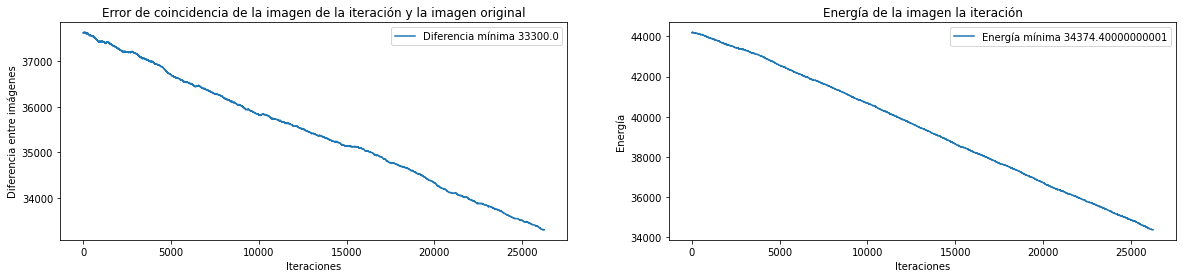

(-0.5, 179.5, 149.5, -0.5)

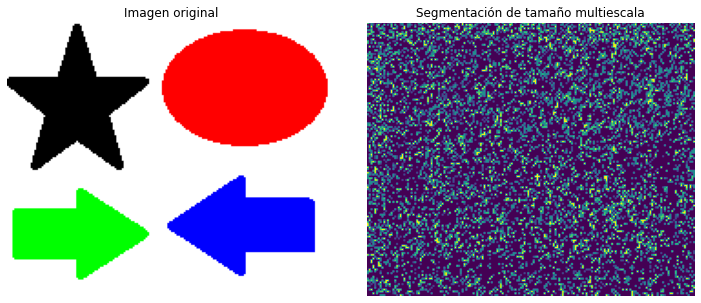

In [ ]:
##Gráfica del error con respecto a la imagen original
fi,ax=plt.subplots(1,2)
fi.set_size_inches(20,4)

ax[0].plot(Er,label=f"Diferencia mínima {min(Er)}")
ax[0].set_xlabel("Iteraciones")
ax[0].set_ylabel("Diferencia entre imágenes")
ax[0].legend()
ax[0].set_title("Error de coincidencia de la imagen de la iteración y la imagen original")

##Gráfica de la energía en la iteración i-ésima

ax[1].plot(Ep,label=f"Energía mínima {min(Ep)}")
ax[1].legend()
ax[1].set_xlabel("Iteraciones")
ax[1].set_ylabel("Energía")
ax[1].set_title("Energía de la imagen la iteración")
plt.show()

##Resultados de la segmentación binaria

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,10)
fig.tight_layout(pad=0.1)
axs[0].imshow(im0)
axs[0].set_title("Imagen original")
axs[0].axis("off")
axs[1].imshow(x[i-1])
axs[1].set_title("Segmentación de tamaño multiescala")
axs[1].axis("off")

####Animación

In [ ]:
%%capture
fig,ax = plt.subplots();
def animate(i):
       ax.clear()
       ax.set_axis_off()
       ax.imshow(x[100*i],cmap="gray")
ani = animation.FuncAnimation(fig,animate,frames=260,interval=60,blit=False)
rc('animation', html='jshtml')

In [ ]:
Javascript('document.querySelector(".anim-state").state.value="once" ')
Javascript('document.querySelector(".anim-controls > button:nth-child(6)").click()')
ani

In [ ]:
ani.save("ani1.mp4")